In [1]:
# Bagging and Boosting
# Example of using bagging and boosting regressors for supervised learning when the target variable is "bounded" by floor 
# and ceiling values. By design, tree-based models don't extrapolate outside the target variable range from the training 
# data set; however in this example we demonstrate it is possible for boosting algorithms to produce models that make 
# predictions outside the range observed in the data. We'll also look at a few options for mitigating these prediction 
# errors, such as transforming the target variable to restrict it to a positive number when making predictions. The example
# data set has hourly power output from a wind farm (i.e. the target variable) with forecasted weather variables as features. 
import sys
import time
import pandas as pd
import numpy as np
import sqlalchemy
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, HistGradientBoostingRegressor
from sklearn.metrics import mean_squared_error
import xgboost
from xgboost import XGBRFRegressor, XGBRegressor
import plotnine
plotnine.options.figure_size = (9,4.5)
from plotnine import ggplot, aes, geom_histogram, geom_point, geom_smooth, labs, theme_bw, geom_vline
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Library Versions
print(f"Python {sys.version.split()[0]}")
print(f"NumPy {np.__version__}")
print(f"SQL Alchemy {sqlalchemy.__version__}")
print(f"Pandas {pd.__version__}")
print(f"plotnine {plotnine.__version__}")
print(f"SciKit-Learn {sklearn.__version__}")
print(f"XG Boost {xgboost.__version__}")

Python 3.10.5
NumPy 1.23.2
SQL Alchemy 1.4.40
Pandas 1.4.3
plotnine 0.10.1
SciKit-Learn 1.1.2
XG Boost 1.7.1


In [3]:
# Get Data Frame
sqlquery = """
SELECT TOP (10000) *
FROM [wind].[GetTrainData]
WHERE [Wind] = 'BBWF'
ORDER BY NEWID();
"""
constr = "mssql+pyodbc://RECKONDEV/DataScience?driver=ODBC+Driver+17+for+SQL+Server&TRUSTED_CONNECTION=Yes"
dbcon = sqlalchemy.create_engine(constr)
df = pd.read_sql_query(sql = sqlquery, con = dbcon, parse_dates = ["initTimeUTC","validTimeUTC"])
df.describe()

,mod00z,mod06z,mod12z,mod18z,modGFS,modNAM,yMW,yMWlogit,forecastHour,t2m,...,pblh,refl,t700,td700,hodsin,hodcos,doysin,doycos,dowsin,dowcos
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,...,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,0.340600,0.163000,0.336000,0.160400,0.362800,0.637200,6.845920,-1.964781,43.807900,9.342424,...,636.539745,-14.074424,0.183985,-11.178052,0.501917,0.502787,0.491337,0.503989,0.502530,0.502808
std,0.473935,0.369384,0.472362,0.366995,0.480832,0.480832,7.628919,3.510384,25.977072,12.175565,...,877.119132,12.152941,9.360790,8.223199,0.355257,0.351965,0.355814,0.351192,0.352844,0.353997
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-6.907000,0.000000,-24.549999,...,0.000000,-20.000000,-23.049999,-48.752998,0.000000,0.000000,0.000000,0.000000,0.013000,0.050000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.200000,-4.659000,21.750000,-0.370000,...,110.000000,-20.000000,-7.150000,-16.017500,0.146000,0.146000,0.139000,0.154000,0.109000,0.050000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,3.200000,-1.733000,43.000000,7.515000,...,303.000000,-20.000000,-1.350000,-10.420000,0.500000,0.500000,0.474000,0.504000,0.500000,0.389000
75%,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000,12.800000,0.409000,66.000000,18.719999,...,712.000000,-15.620000,8.350000,-5.287250,0.854000,0.854000,0.855000,0.852000,0.891000,0.812000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,21.000000,4.248000,96.000000,38.709999,...,6221.000000,50.770000,18.850000,9.293000,1.000000,1.000000,1.000000,1.000000,0.987000,1.000000


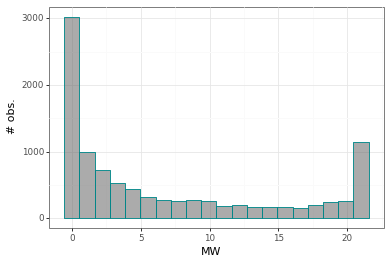

<ggplot: (191587551602)>

In [4]:
# Histogram of Target Variable
# Distribution is right skewed, with many values equal to or close to 0
p = (
    ggplot(df, aes(x = "yMW"))
    + geom_histogram(color = "#008789", alpha = 0.5, bins = 20)
    + labs(x = "MW", y = "# obs.")
    + theme_bw()
)
p

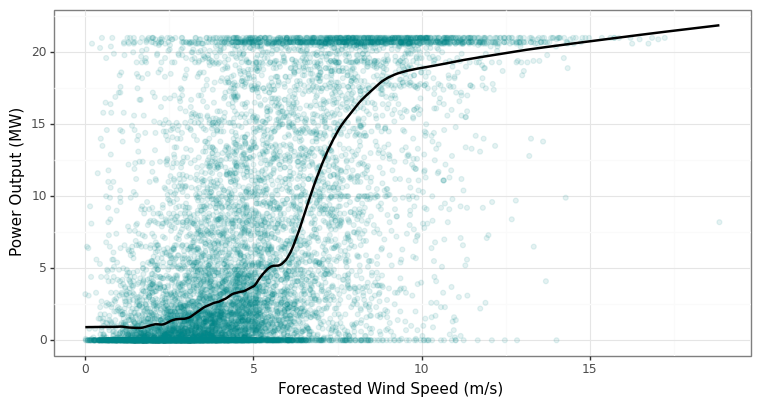

<ggplot: (191588109544)>

In [5]:
# Forecast Wind Speed x Power Generation
p = (
    ggplot(df, aes(x = "ws", y = "yMW"))
    + geom_point(color = "#008789", alpha = 0.1)
    + geom_smooth(se = False, method = "lowess", span = 0.1)
    + labs(x = "Forecasted Wind Speed (m/s)", y = "Power Output (MW)")
    + theme_bw()
)
p

In [6]:
# Get Maximum Target Value
mw = df.yMW.max()
print(f"Maximum MW = {mw}")

Maximum MW = 21.0


In [7]:
# X and y data partitions for model training
# Features (X) are forecasting weather variables like temperature, wind speed, direction
# Target (y) is the generation output from a wind farm
# Each row is an hour, indexed by Date/Time column
xvars = ["forecastHour","t2d","t2m","u10","v10","ws","wdsin","wdcos","pblh","refl","hodsin","hodcos","doysin","doycos"]
Xdf = df.loc[:,xvars]
ydf = np.ravel(df.loc[:,["yMW"]]) / mw
print(f"X {Xdf.shape}")
print(f"y {ydf.shape}")

X (10000, 14)
y (10000,)


In [8]:
# Training/testing partition
# Note this is technically a time series data set, so for proper parameter tuning and model evaluation we would use 
# TimeSeriesSplit instead of train_test_split, but we'll use a simple partition for demonstration purposes.
Xdftrain, Xdftest, ydftrain, ydftest = train_test_split(Xdf, ydf, test_size = 0.2)
print(f"Training Features {Xdftrain.shape}")
print(f"Testing Features {Xdftest.shape}")
print(f"Training Target {ydftrain.shape}")
print(f"Testing Target {ydftest.shape}")

Training Features (8000, 14)
Testing Features (2000, 14)
Training Target (8000,)
Testing Target (2000,)


In [9]:
# Print summary stats of the target variable of the training partition
print(f"Minimum = {ydftrain.min():.3}")
print(f"Maximum = {ydftrain.max():.3}")
print(f"   Mean = {ydftrain.mean():.3}")
print(f"Std Dev = {ydftrain.std():.3}")

Minimum = 0.0
Maximum = 1.0
   Mean = 0.326
Std Dev = 0.363


In [10]:
# Make a list of maximum depth values, these are used for the bagging and boosting algorithms
# Also, we'll hold the number of trees/iterations to 500 for all the examples
mdlist = [1,2,4,8,16,32]
ntrees = 500
print(f"Max Depths: {mdlist}")
print(f"Trees: {ntrees}")

Max Depths: [1, 2, 4, 8, 16, 32]
Trees: 500

Trees: 500


In [11]:
# Fancy Print Function
def funprint(mxdp, prmin, prmax, prer, dur):
    mn = f"{prmin:.2f}"
    mx = f"{prmax:.2f}"
    er = f"{prer:.2f}"
    tm = f"{dur:.2f}"
    print(f"| {mxdp:5d} | {mn:>7} | {mx:>7} | {er:>7} | {tm:>8} |")

Random Forest Regressor (Sci-Kit Learn)
--------------------------------------------------
| depth | minimum | maximum |   rmse  | duration |
--------------------------------------------------
|     1 |    0.21 |    0.65 |    0.30 |     2.09 |
|     2 |    0.13 |    0.75 |    0.29 |     3.59 |
|     4 |    0.09 |    0.88 |    0.27 |     6.62 |
|     8 |    0.05 |    0.94 |    0.26 |    12.70 |
|    16 |    0.01 |    0.97 |    0.25 |    25.29 |
|    32 |    0.01 |    0.98 |    0.25 |    29.24 |
--------------------------------------------------


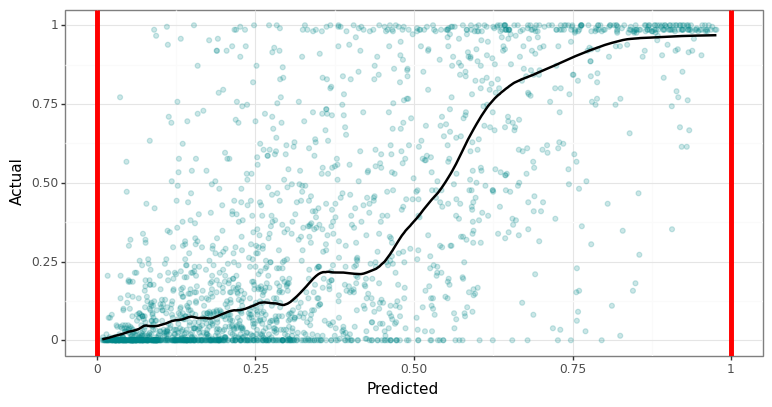

<ggplot: (191587830214)>

In [12]:
# Random Forest Regressor in Sci-Kit Learn
# https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html
# Other criterion: squared_error, absolute_error, freidman_mse, poisson
print("Random Forest Regressor (Sci-Kit Learn)")
print("--------------------------------------------------")
print("| depth | minimum | maximum |   rmse  | duration |")
print("--------------------------------------------------")
for md in mdlist:
    t1 = time.perf_counter()
    mod = RandomForestRegressor(
        criterion = "friedman_mse", 
        max_depth = md,
        n_estimators = ntrees
    ).fit(Xdftrain, ydftrain)
    t2 = time.perf_counter()
    pred = mod.predict(Xdftest)
    rmse = np.sqrt(mean_squared_error(ydftest, pred))
    funprint(md, pred.min(), pred.max(), rmse, t2-t1)
print("--------------------------------------------------")
dfplt = pd.DataFrame({"yMW": ydftest, "xMW": mod.predict(Xdftest)})
p = (
    ggplot(dfplt, aes(x = "xMW", y = "yMW"))
    + geom_point(alpha = 0.2, color = "#008789")
    + geom_smooth(method = "lowess", span = 0.1)
    + labs(x = "Predicted", y = "Actual")
    + geom_vline(xintercept = [ydftrain.min(), ydftrain.max()], color = ["red","red"], size = [2,2])
    + theme_bw()
)
p

XGB RF Regressor
--------------------------------------------------
| depth | minimum | maximum |   rmse  | duration |
--------------------------------------------------
|     1 |    0.21 |    0.65 |    0.30 |     0.79 |
|     2 |    0.15 |    0.76 |    0.29 |     0.53 |
|     4 |    0.09 |    0.87 |    0.27 |     0.92 |
|     8 |    0.05 |    0.94 |    0.26 |     2.13 |
|    16 |    0.01 |    0.98 |    0.25 |    10.51 |
|    32 |    0.00 |    0.99 |    0.25 |    19.22 |
--------------------------------------------------


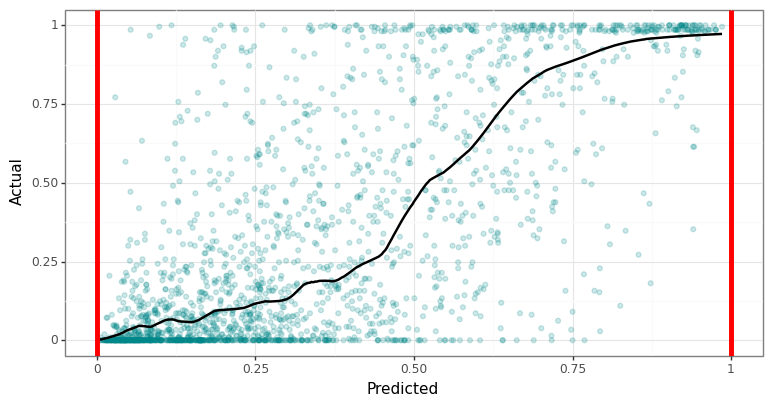

<ggplot: (191587836268)>

In [13]:
# Random Forest Regressor in XGBoost
# https://xgboost.readthedocs.io/en/stable/tutorials/rf.html
# https://xgboost.readthedocs.io/en/latest/parameter.html
# Other objectives = reg:squarederror, reg:squaredlogerror, reg:logistic, reg:pseudohubererror, count:poisson, reg:gamma, reg:tweedie
print("XGB RF Regressor")
print("--------------------------------------------------")
print("| depth | minimum | maximum |   rmse  | duration |")
print("--------------------------------------------------")
for md in mdlist:
    t1 = time.perf_counter()
    mod = XGBRFRegressor(
        objective = "reg:squarederror", 
        max_depth = md,
        n_estimators = ntrees
    ).fit(Xdftrain, ydftrain)
    t2 = time.perf_counter()
    pred = mod.predict(Xdftest)
    rmse = np.sqrt(mean_squared_error(ydftest, pred))
    funprint(md, pred.min(), pred.max(), rmse, t2-t1)
print("--------------------------------------------------")
dfplt = pd.DataFrame({"yMW": ydftest, "xMW": mod.predict(Xdftest)})
p = (
    ggplot(dfplt, aes(x = "xMW", y = "yMW"))
    + geom_point(alpha = 0.2, color = "#008789")
    + geom_smooth(method = "lowess", span = 0.1)
    + labs(x = "Predicted", y = "Actual")
    + geom_vline(xintercept = [ydftrain.min(), ydftrain.max()], color = ["red","red"], size = [2,2])
    + theme_bw()
)
p

<AxesSubplot:ylabel='Feature'>

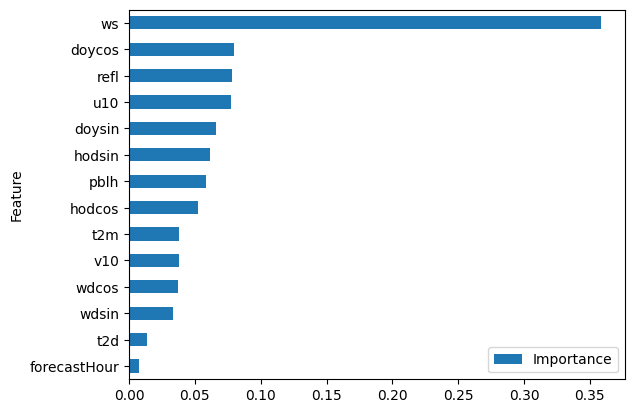

In [14]:
# RF Feature Importance
dffi = pd.DataFrame({"Feature": xvars, "Importance": mod.feature_importances_}).set_index("Feature").sort_values("Importance")
dffi.plot(kind = "barh")

In [15]:
# Boosting Algorithms
# We'll try max depth as well as learning rate for boosting algos
lrlist = [0.01,0.1,1.0]
print(f"Learning Rates: {lrlist}")

Learning Rates: [0.01, 0.1, 1.0]


Gradient Boosting Regressor w/ Squared Error Loss
--------------------------------------------------
| depth | minimum | maximum |   rmse  | duration |
--------------------------------------------------
Learning Rate = 0.01
|     1 |    0.06 |    0.78 |    0.28 |     3.16 |
|     2 |    0.02 |    0.91 |    0.27 |     6.07 |
|     4 |    0.02 |    0.98 |    0.26 |    11.46 |
|     8 |   -0.00 |    0.99 |    0.25 |    22.42 |
|    16 |   -0.00 |    1.01 |    0.29 |    40.77 |
|    32 |    0.00 |    1.00 |    0.34 |    50.30 |
Learning Rate = 0.1
|     1 |   -0.07 |    1.03 |    0.27 |     2.99 |
|     2 |   -0.09 |    1.08 |    0.26 |     6.04 |
|     4 |   -0.19 |    1.26 |    0.25 |    11.84 |
|     8 |   -0.07 |    1.26 |    0.25 |    23.09 |
|    16 |   -0.03 |    1.02 |    0.29 |    44.47 |
|    32 |   -0.00 |    1.00 |    0.34 |    15.96 |
Learning Rate = 1.0
|     1 |   -0.15 |    1.10 |    0.27 |     3.02 |
|     2 |   -0.54 |    1.54 |    0.29 |     5.85 |
|     4 |   -0.66 |   

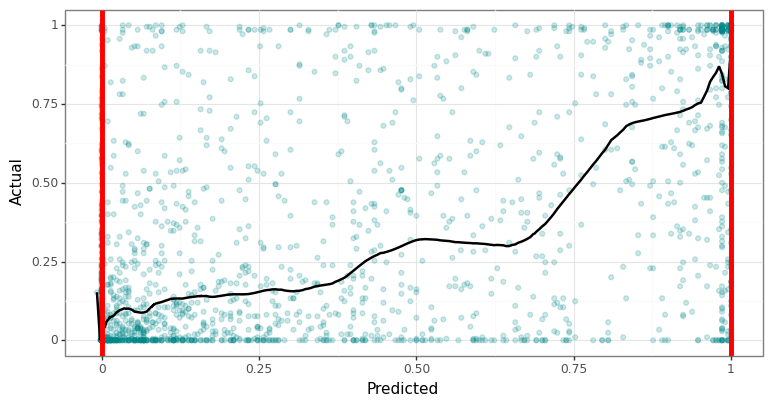

<ggplot: (191588223871)>

In [16]:
# Gradient Boosting Regressor
# https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingRegressor.html
# Other loss options: squared_error, absolute_error, huber, quantile (requires alpha)
print("Gradient Boosting Regressor w/ Squared Error Loss")
print("--------------------------------------------------")
print("| depth | minimum | maximum |   rmse  | duration |")
print("--------------------------------------------------")
for lr in lrlist:
    print(f"Learning Rate = {lr}")
    for md in mdlist:
        t1 = time.perf_counter()
        mod = GradientBoostingRegressor(
            loss = "squared_error",
            max_depth = md,
            learning_rate = lr,
            n_estimators = ntrees
        ).fit(Xdftrain, ydftrain)
        t2 = time.perf_counter()
        pred = mod.predict(Xdftest)
        rmse = np.sqrt(mean_squared_error(ydftest, pred))
        funprint(md, pred.min(), pred.max(), rmse, t2-t1)
print("--------------------------------------------------")
dfplt = pd.DataFrame({"yMW": ydftest, "xMW": mod.predict(Xdftest)})
p = (
    ggplot(dfplt, aes(x = "xMW", y = "yMW"))
    + geom_point(alpha = 0.2, color = "#008789")
    + geom_smooth(method = "lowess", span = 0.1)
    + labs(x = "Predicted", y = "Actual")
    + geom_vline(xintercept = [ydftrain.min(), ydftrain.max()], color = ["red","red"], size = [2,2])
    + theme_bw()
)
p

Hist Gradient Boosting Regressor w/ Squared Error Loss
--------------------------------------------------
| depth | minimum | maximum |   rmse  | duration |
--------------------------------------------------
Learning Rate = 0.01
|     1 |    0.06 |    0.78 |    0.28 |     0.41 |
|     2 |    0.03 |    0.91 |    0.27 |     0.47 |
|     4 |   -0.00 |    0.98 |    0.26 |     1.08 |
|     8 |    0.02 |    0.99 |    0.25 |     2.62 |
|    16 |    0.01 |    0.99 |    0.25 |     2.86 |
|    32 |    0.01 |    0.99 |    0.25 |     2.77 |
Learning Rate = 0.1
|     1 |   -0.07 |    1.02 |    0.27 |     0.36 |
|     2 |   -0.09 |    1.16 |    0.26 |     0.47 |
|     4 |   -0.11 |    1.19 |    0.25 |     1.02 |
|     8 |   -0.09 |    1.14 |    0.24 |     2.42 |
|    16 |   -0.12 |    1.14 |    0.25 |     2.45 |
|    32 |   -0.08 |    1.18 |    0.25 |     2.66 |
Learning Rate = 1.0
|     1 |   -0.13 |    1.15 |    0.27 |     0.37 |
|     2 |   -0.34 |    1.40 |    0.27 |     0.50 |
|     4 |   -0.76

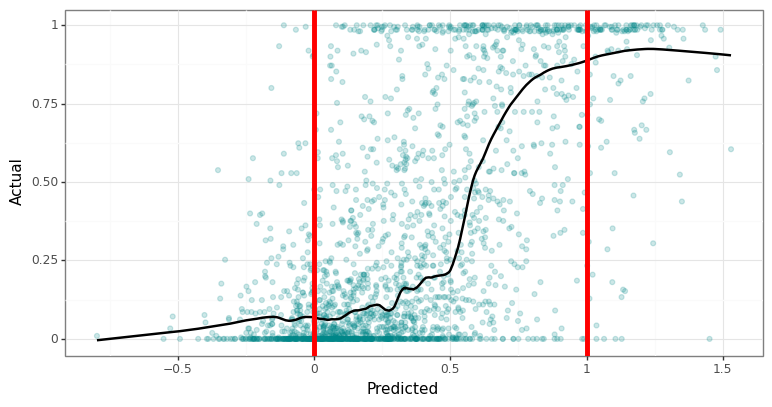

<ggplot: (191588470331)>

In [17]:
# Hist Gradient Boosting Regressor
# https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.HistGradientBoostingRegressor.html
# Other loss options: squared_error, absolute_error, poisson, quantile (requires quantile)
print("Hist Gradient Boosting Regressor w/ Squared Error Loss")
print("--------------------------------------------------")
print("| depth | minimum | maximum |   rmse  | duration |")
print("--------------------------------------------------")
for lr in lrlist:
    print(f"Learning Rate = {lr}")
    for md in mdlist:
        t1 = time.perf_counter()
        mod = HistGradientBoostingRegressor(
            loss = "squared_error",
            max_depth = md,
            learning_rate = lr,
            max_iter = ntrees
        ).fit(Xdftrain, ydftrain)
        t2 = time.perf_counter()
        pred = mod.predict(Xdftest)
        rmse = np.sqrt(mean_squared_error(ydftest, pred))
        funprint(md, pred.min(), pred.max(), rmse, t2-t1)
print("--------------------------------------------------")
dfplt = pd.DataFrame({"yMW": ydftest, "xMW": mod.predict(Xdftest)})
p = (
    ggplot(dfplt, aes(x = "xMW", y = "yMW"))
    + geom_point(alpha = 0.2, color = "#008789")
    + geom_smooth(method = "lowess", span = 0.1)
    + labs(x = "Predicted", y = "Actual")
    + geom_vline(xintercept = [ydftrain.min(), ydftrain.max()], color = ["red","red"], size = [2,2])
    + theme_bw()
)
p

Hist Gradient Boosting Regressor w/ Quantile Loss
--------------------------------------------------
| depth | minimum | maximum |   rmse  | duration |
--------------------------------------------------
Learning Rate = 0.01
|     1 |   -0.01 |    0.94 |    0.29 |     0.69 |
|     2 |   -0.01 |    1.01 |    0.29 |     0.90 |
|     4 |   -0.01 |    1.04 |    0.27 |     2.34 |
|     8 |   -0.05 |    1.00 |    0.27 |     5.09 |
|    16 |   -0.07 |    1.01 |    0.27 |     5.02 |
|    32 |   -0.07 |    1.01 |    0.27 |     4.99 |
Learning Rate = 0.1
|     1 |   -0.05 |    1.05 |    0.29 |     0.64 |
|     2 |   -0.04 |    1.12 |    0.28 |     0.91 |
|     4 |   -0.08 |    1.22 |    0.26 |     1.95 |
|     8 |   -0.12 |    1.11 |    0.26 |     4.45 |
|    16 |   -0.16 |    1.12 |    0.26 |     4.64 |
|    32 |   -0.07 |    1.14 |    0.26 |     4.61 |
Learning Rate = 1.0
|     1 |    0.00 |    0.76 |    0.30 |     0.66 |
|     2 |   -0.14 |    1.18 |    0.28 |     0.90 |
|     4 |   -0.37 |   

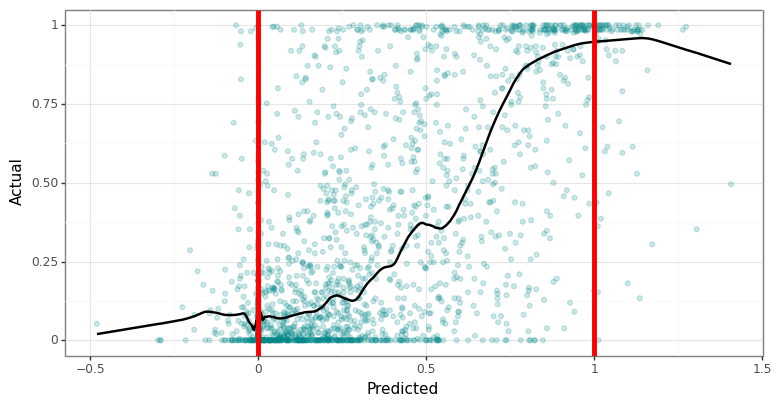

<ggplot: (191588060740)>

In [18]:
# Hist Gradient Boosting Regressor with Quantile Loss
print("Hist Gradient Boosting Regressor w/ Quantile Loss")
print("--------------------------------------------------")
print("| depth | minimum | maximum |   rmse  | duration |")
print("--------------------------------------------------")
for lr in lrlist:
    print(f"Learning Rate = {lr}")
    for md in mdlist:
        t1 = time.perf_counter()
        mod = HistGradientBoostingRegressor(
            max_depth = md,
            learning_rate = lr,
            loss = "quantile",
            quantile = 0.5,
            max_iter = ntrees
        ).fit(Xdftrain, ydftrain)
        t2 = time.perf_counter()
        pred = mod.predict(Xdftest)
        rmse = np.sqrt(mean_squared_error(ydftest, pred))
        funprint(md, pred.min(), pred.max(), rmse, t2-t1)
print("--------------------------------------------------")
dfplt = pd.DataFrame({"yMW": ydftest, "xMW": mod.predict(Xdftest)})
p = (
    ggplot(dfplt, aes(x = "xMW", y = "yMW"))
    + geom_point(alpha = 0.2, color = "#008789")
    + geom_smooth(method = "lowess", span = 0.1)
    + labs(x = "Predicted", y = "Actual")
    + geom_vline(xintercept = [ydftrain.min(), ydftrain.max()], color = ["red","red"], size = [2,2])
    + theme_bw()
)
p

XGB Regressor w/ Squared Error Objective
--------------------------------------------------
| depth | minimum | maximum |   rmse  | duration |
--------------------------------------------------
Learning Rate = 0.01
|     1 |    0.07 |    0.78 |    0.28 |     0.20 |
|     2 |    0.03 |    0.91 |    0.27 |     0.21 |
|     4 |    0.01 |    0.98 |    0.26 |     0.33 |
|     8 |   -0.01 |    1.02 |    0.25 |     1.25 |
|    16 |   -0.01 |    1.00 |    0.26 |    11.41 |
|    32 |   -0.00 |    1.01 |    0.27 |    17.70 |
Learning Rate = 0.1
|     1 |   -0.07 |    1.02 |    0.27 |     0.18 |
|     2 |   -0.09 |    1.11 |    0.26 |     0.20 |
|     4 |   -0.09 |    1.15 |    0.25 |     0.32 |
|     8 |   -0.07 |    1.09 |    0.25 |     1.08 |
|    16 |   -0.02 |    1.01 |    0.26 |     2.52 |
|    32 |   -0.01 |    1.01 |    0.26 |     3.19 |
Learning Rate = 1.0
|     1 |   -0.13 |    1.13 |    0.27 |     0.15 |
|     2 |   -0.43 |    1.40 |    0.27 |     0.20 |
|     4 |   -0.51 |    1.48 |  

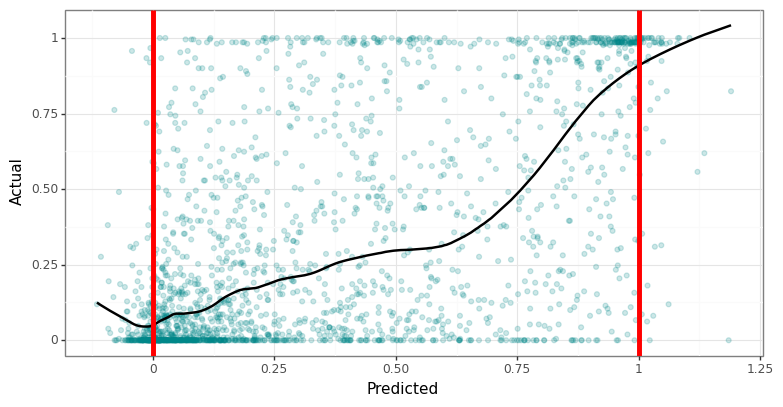

<ggplot: (191587884477)>

In [19]:
# XGB Regressor
# https://xgboost.readthedocs.io/en/latest/python/python_api.html
print("XGB Regressor w/ Squared Error Objective")
print("--------------------------------------------------")
print("| depth | minimum | maximum |   rmse  | duration |")
print("--------------------------------------------------")
for lr in lrlist:
    print(f"Learning Rate = {lr}")
    for md in mdlist:
        t1 = time.perf_counter()
        mod = XGBRegressor(
            objective = "reg:squarederror",
            tree_method = "hist",
            max_depth = md,
            learning_rate = lr,
            n_estimators = ntrees
        ).fit(Xdftrain, ydftrain)
        t2 = time.perf_counter()
        pred = mod.predict(Xdftest)
        rmse = np.sqrt(mean_squared_error(ydftest, pred))
        funprint(md, pred.min(), pred.max(), rmse, t2-t1)
print("--------------------------------------------------")
dfplt = pd.DataFrame({"yMW": ydftest, "xMW": mod.predict(Xdftest)})
p = (
    ggplot(dfplt, aes(x = "xMW", y = "yMW"))
    + geom_point(alpha = 0.2, color = "#008789")
    + geom_smooth(method = "lowess", span = 0.2)
    + labs(x = "Predicted", y = "Actual")
    + geom_vline(xintercept = [ydftrain.min(), ydftrain.max()], color = ["red","red"], size = [2,2])
    + theme_bw()
)
p

<AxesSubplot:ylabel='Feature'>

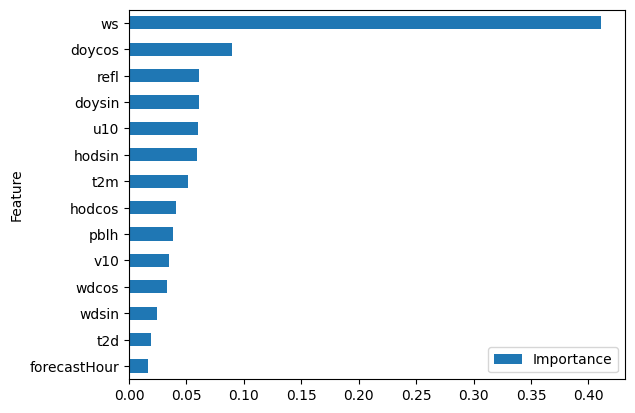

In [20]:
# XGB Feature Importance
dffi = pd.DataFrame({"Feature": xvars, "Importance": mod.feature_importances_}).set_index("Feature").sort_values("Importance")
dffi.plot(kind = "barh")

XGB Regressor w/ Logistic Objective
--------------------------------------------------
| depth | minimum | maximum |   rmse  | duration |
--------------------------------------------------
Learning Rate = 0.01
|     1 |    0.10 |    0.76 |    0.28 |     0.19 |
|     2 |    0.07 |    0.88 |    0.27 |     0.21 |
|     4 |    0.05 |    0.94 |    0.26 |     0.34 |
|     8 |    0.02 |    0.98 |    0.25 |     1.05 |
|    16 |    0.01 |    0.98 |    0.25 |     3.80 |
|    32 |    0.01 |    0.98 |    0.25 |     4.94 |
Learning Rate = 0.1
|     1 |    0.03 |    0.95 |    0.27 |     0.17 |
|     2 |    0.02 |    0.98 |    0.26 |     0.21 |
|     4 |    0.01 |    1.00 |    0.25 |     0.31 |
|     8 |    0.00 |    1.00 |    0.24 |     0.87 |
|    16 |    0.00 |    1.00 |    0.25 |     2.67 |
|    32 |    0.00 |    1.00 |    0.25 |     4.12 |
Learning Rate = 1.0
|     1 |    0.02 |    0.98 |    0.27 |     0.17 |
|     2 |    0.00 |    1.00 |    0.27 |     0.20 |
|     4 |    0.00 |    1.00 |    0.2

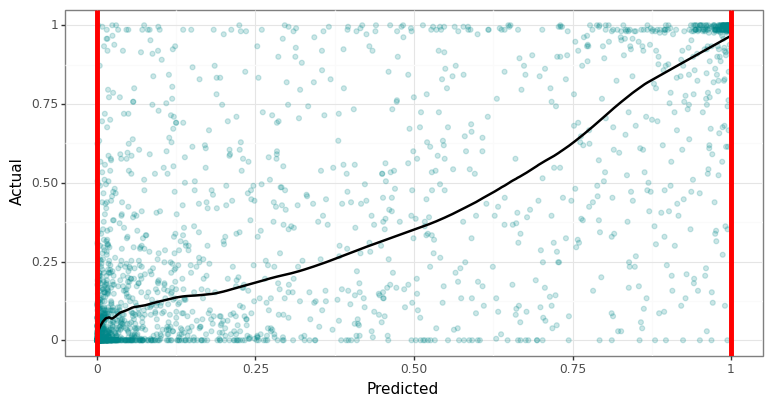

<ggplot: (191626864517)>

In [21]:
# XGB Regressor with Logistic Objective
# Use objective = 'reg:logistic' in XGBRegressor
print("XGB Regressor w/ Logistic Objective")
print("--------------------------------------------------")
print("| depth | minimum | maximum |   rmse  | duration |")
print("--------------------------------------------------")
for lr in lrlist:
    print(f"Learning Rate = {lr}")
    for md in mdlist:
        t1 = time.perf_counter()
        mod = XGBRegressor(
            tree_method = "hist",
            max_depth = md,
            learning_rate = lr,
            objective = "reg:logistic", 
            n_estimators = ntrees
        ).fit(Xdftrain, ydftrain)
        t2 = time.perf_counter()
        pred = mod.predict(Xdftest)
        rmse = np.sqrt(mean_squared_error(ydftest, pred))
        funprint(md, pred.min(), pred.max(), rmse, t2-t1)
print("--------------------------------------------------")
dfplt = pd.DataFrame({"yMW": ydftest, "xMW": mod.predict(Xdftest)})
p = (
    ggplot(dfplt, aes(x = "xMW", y = "yMW"))
    + geom_point(alpha = 0.2, color = "#008789")
    + geom_smooth(method = "lowess", span = 0.2)
    + labs(x = "Predicted", y = "Actual")
    + geom_vline(xintercept = [ydftrain.min(), ydftrain.max()], color = ["red","red"], size = [2,2])
    + theme_bw()
)
p

In [22]:
# Sci-Kit Learn TransformedTargetRegressor
# build a model pipeline 
# (https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html#sklearn.pipeline.Pipeline) 
# with one of the steps using Transformed Target Regressor 
# (https://scikit-learn.org/stable/modules/generated/sklearn.compose.TransformedTargetRegressor.html#)
from sklearn.compose import TransformedTargetRegressor
from sklearn.preprocessing import QuantileTransformer
from sklearn.pipeline import make_pipeline

In [23]:
# Make Model Pipeline with Transformed Target Regressor
pipe = make_pipeline(
    TransformedTargetRegressor(
        regressor = XGBRegressor(
            tree_method = "hist",
            n_estimators = 500,
            max_depth = 8,
            learning_rate = 0.01
        ),
        transformer = QuantileTransformer(
            output_distribution = "uniform"
        )
    )
).fit(Xdftrain, ydftrain)
pred = pipe.predict(Xdftest)

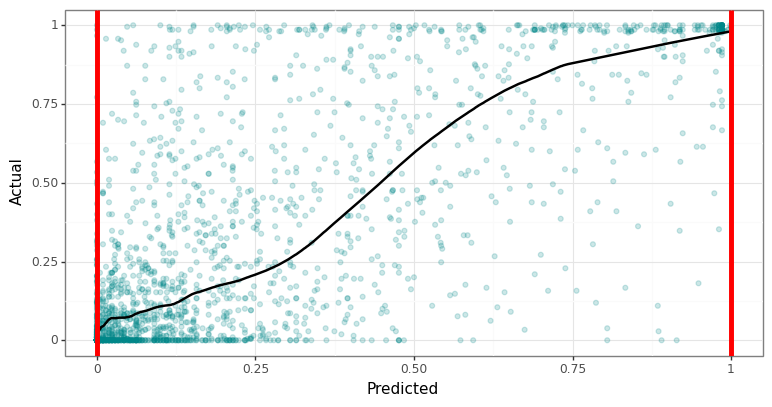

<ggplot: (191626680972)>

In [24]:
# Plot Pipeline Model Predictions
dfplt = pd.DataFrame({"yMW": ydftest, "xMW": pred})
p = (
    ggplot(dfplt, aes(x = "xMW", y = "yMW"))
    + geom_point(alpha = 0.2, color = "#008789")
    + geom_smooth(method = "lowess", span = 0.2)
    + labs(x = "Predicted", y = "Actual")
    + geom_vline(xintercept = [ydftrain.min(), ydftrain.max()], color = ["red","red"], size = [2,2])
    + theme_bw()
)
p

In [25]:
# Print Predicted Min/Max Values
print(f"Predicted Min = {pred.min():.1f}")
print(f"Predicted Max = {pred.max():.1f}")

Predicted Min = 0.0
Predicted Max = 1.0
